In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pyBigWig
import pysam
from tqdm import tqdm
from scipy import stats

## Coverage Uniformity

In [38]:
with open('../bin/benchmarking/PTA_names.txt', 'r') as fin:
    PTA_names = [line.strip() for line in fin if line.strip() != 'SRR8438299']
with open('../bin/benchmarking/LIANTI_names.txt', 'r') as fin:
    LIANTI_names = [line.strip() for line in fin]
with open('../bin/benchmarking/shallow_CapWGS_names.txt', 'r') as fin:
    shallow_CapWGS_names = [line.strip() for line in fin]

names = PTA_names + LIANTI_names + shallow_CapWGS_names

In [39]:
pal = {
    'PTA': '#5AAA46',
    'MDA': '#F2B342',
    'LIANTI': '#C03830',
    'MALBAC': '#C43E96',
    'Bulk': '#825CA6',
    'shallow_CapWGS': '#317EC2'
}

In [18]:
meta_1 = pd.read_csv('../bin/benchmarking/PTA_meta.tsv', sep='\t', index_col='SRA_Run')
meta_1=meta_1[meta_1['amplification_method'].isin(['PTA','SCMDA'])]
def rename(row):
    if row.amplification_method=='SCMDA':
        return 'MDA' 
    else:
        return row.amplification_method
meta_1['amplification_method'] = meta_1.apply(rename, axis=1)
meta_1['study']='Gonzalez-Pena'
meta_1=meta_1[['study','amplification_method']]
# meta_1

In [19]:
meta_2 = pd.read_csv('../bin/benchmarking/LIANTI_meta.tsv', sep='\t', index_col='SRA_Run')
meta_2['study'] = 'Chen'

def amp(row):
    if 'LIANTI' in row.replicate:
        return 'LIANTI' 
    elif 'MDA' in row.replicate:
        return 'MDA' 
    elif 'MALBAC' in row.replicate:
        return 'MALBAC'
    elif 'Bulk' in row.replicate:
        return 'Bulk'
    
meta_2['amplification_method'] = meta_2.apply(amp, axis=1)
meta_2 = meta_2[meta_2['amplification_method'].isin(['LIANTI','MDA','MALBAC','Bulk'])]
meta_2 = meta_2[['study','amplification_method']]
# meta_2

In [42]:
meta_3 = pd.DataFrame(index=shallow_CapWGS_names)
meta_3['amplification_method'] = "shallow_CapWGS"
meta_3['study'] = "CapWGS"


In [43]:
meta = pd.concat([meta_1, meta_2, meta_3])
meta

,study,amplification_method
SRR8438254,Gonzalez-Pena,PTA
SRR8438256,Gonzalez-Pena,PTA
SRR8438258,Gonzalez-Pena,PTA
SRR8438259,Gonzalez-Pena,PTA
SRR8438298,Gonzalez-Pena,PTA
...,...,...
TATCAGCCAGGACGCTACTAACTCGCAATGACAAGGCGGTTGATA,CapWGS,shallow_CapWGS
TATCAGCCAGGACTTCAGCAACTCTGCTATGGAAGGTTCCACTCA,CapWGS,shallow_CapWGS
TGTGGTTGAGGACCATACGAACTCGTGTGATGAAGGGGCATCAAA,CapWGS,shallow_CapWGS
TGTGGTTGAGGACTTCAGCAACTCTAACGGAGAAGGAGATACCGA,CapWGS,shallow_CapWGS


In [44]:
coverages = {name : pd.read_csv(f"../data/benchmarking/binned_coverage/{name}.csv", header=None)[0].to_list() for name in names}
coverages = pd.DataFrame(data=coverages)

In [48]:
lorenz_curves = {}
ginis = []
for name in meta.index:
    prop = coverages[name] / coverages[name].sum()
    prop = prop[prop>0] 
    y = np.cumsum(prop.sort_values())
    x = np.arange(len(prop))
    x = x / len(x)
    x = np.concatenate(([0], x))
    y = np.concatenate(([0], y))
    lorenz_curves[name] = y
    auc = np.trapezoid(y, x)
    gini = 1 - 2 * auc
    ginis.append(gini)
    
meta['gini'] = ginis

common_x = np.linspace(0, 1, 100)

for name,arr in lorenz_curves.items():
    # Original x scale for the array (0 to 1, evenly spaced)
    original_x = np.linspace(0, 1, len(arr))
    # Interpolate to the common scale
    rescaled_y = np.interp(common_x, original_x, arr)
    lorenz_curves[name]=rescaled_y

lorenz_curves = pd.DataFrame(data=lorenz_curves, index=common_x)

/loc/scratch/39703346/ipykernel_35904/41285143.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=meta, x="amplification_method", y="gini",


Text(0, 0.5, 'Gini Coefficient')

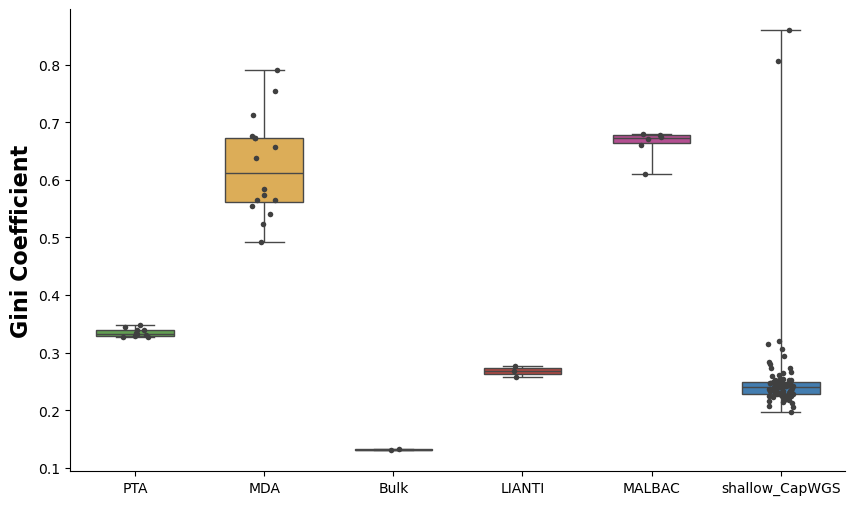

In [53]:
# sns.set_theme(style="ticks", palette="pastel")
fig,ax = plt.subplots(1,1,figsize=(10,6))
sns.boxplot(data=meta, x="amplification_method", y="gini",
            ax=ax,
            palette=pal,
            whis=(0,100),
            width=.6
           )

sns.stripplot(data=meta, x="amplification_method", y="gini",
              ax=ax,
              size=4, 
              color=".25"
             )

sns.despine()
plt.xlabel('')
# plt.ylim(0.175,0.4)
plt.ylabel('Gini Coefficient', fontdict={'weight':'bold','size':16})

Text(0, 0.5, 'Cumulative Fraction of Total Reads')

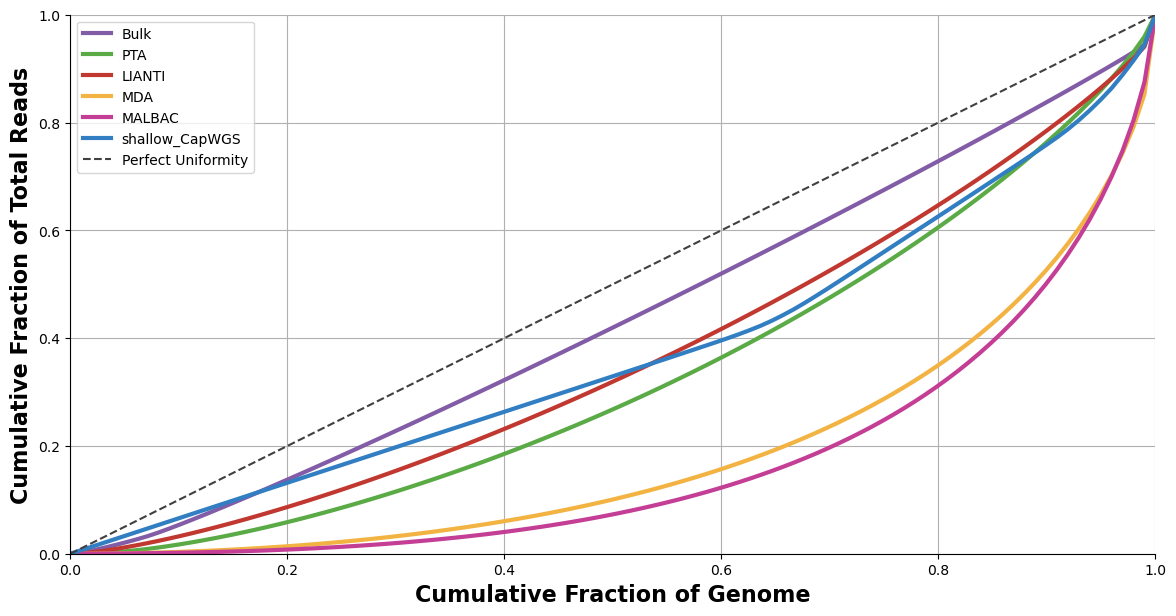

In [54]:
# Calculate mean and standard deviation of Lorenz curves for each group
mean_curves = {}
std_curves = {}
for group in meta['amplification_method'].unique():
    subset = lorenz_curves[meta[meta['amplification_method']==group].index]  # Select Lorenz curves for the group
    mean_curves[group] = subset.mean(axis=1)  # Mean across barcodes
    std_curves[group] = subset.std(axis=1)    # Standard deviation across barcodes

# Convert to DataFrame for plotting
mean_df = pd.DataFrame(mean_curves)
std_df = pd.DataFrame(std_curves)

plt.figure(figsize=(14, 7))
plt.plot(common_x, mean_df['Bulk'], label='Bulk', color=pal['Bulk'], linewidth=3)
plt.plot(common_x, mean_df['PTA'], label='PTA', color=pal['PTA'], linewidth=3)
plt.plot(common_x, mean_df['LIANTI'], label='LIANTI', color=pal['LIANTI'], linewidth=3)
plt.plot(common_x, mean_df['MDA'], label='MDA', color=pal['MDA'], linewidth=3)
plt.plot(common_x, mean_df['MALBAC'], label='MALBAC', color=pal['MALBAC'], linewidth=3)
plt.plot(common_x, mean_df['shallow_CapWGS'], label='shallow_CapWGS', color=pal['shallow_CapWGS'], linewidth=3)
plt.grid(True)
plt.plot([0,1],[0,1], color='.25', linestyle='--', label='Perfect Uniformity')
plt.legend(title='')
sns.despine()
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('Cumulative Fraction of Genome', fontdict={'weight':'bold','size':16})
plt.ylabel('Cumulative Fraction of Total Reads', fontdict={'weight':'bold','size':16})

## GC Bias, % mapping, % duplicates, etc

In [61]:
PTA_metrics = pd.read_csv('../results/benchmarking/PTA_qc_summary.csv', index_col=0)
PTA_metrics = PTA_metrics[PTA_metrics.index.isin(meta.index)]
# PTA_metrics

In [62]:
LIANTI_metrics = pd.read_csv('../results/benchmarking/LIANTI_qc_summary.csv', index_col=0)
LIANTI_metrics = LIANTI_metrics[LIANTI_metrics.index.isin(meta.index)]
# PTA_metrics

In [63]:
metrics = pd.concat([PTA_metrics, LIANTI_metrics])
meta = pd.merge(meta, metrics, left_index=True, right_index=True)
meta

,study,amplification_method,gini,pct_reads_aligned,mean_read_length,reads_aligned,total_reads,at_dropout,gc_dropout,pct_duplicates,read_pairs_examined,read_pair_duplicates,mean_coverage,median_coverage,pct_1x,pct_10x
SRR8438254,Gonzalez-Pena,PTA,0.340152,0.998890,142.328266,393373122,393810332,2.463873,3.953465,0.264538,393058249,103906582,29.582088,24,0.944510,0.777034
SRR8438256,Gonzalez-Pena,PTA,0.348410,0.998999,142.087322,376201472,376578419,3.084621,2.600622,0.172425,375853409,64717620,28.365647,22,0.946975,0.772341
SRR8438258,Gonzalez-Pena,PTA,0.331572,0.998965,142.257909,397358060,397769597,2.353022,4.301985,0.211232,396960198,83758787,30.239498,25,0.947363,0.788415
SRR8438259,Gonzalez-Pena,PTA,0.339419,0.998896,141.950284,403413288,403859008,2.474044,4.007757,0.222852,403083571,89745871,30.415738,25,0.945227,0.783495
SRR8438298,Gonzalez-Pena,PTA,0.327987,0.998929,142.211162,390038638,390456866,2.505916,4.156542,0.194874,389678898,75850471,29.205149,24,0.947178,0.785615
SRR8438300,Gonzalez-Pena,PTA,0.327949,0.998936,141.874749,389045926,389460434,2.607795,4.007622,0.185810,388726999,72144450,29.211025,24,0.947466,0.786049
SRR8438251,Gonzalez-Pena,PTA,0.344858,0.999006,141.868264,414612331,415024951,3.314676,2.554368,0.182640,414170742,75532828,31.189328,25,0.949177,0.793676
SRR8438252,Gonzalez-Pena,PTA,0.328643,0.998930,142.033839,393434761,393856295,2.454348,4.186280,0.218650,392998032,85835968,29.254556,24,0.946688,0.782807
SRR8438288,Gonzalez-Pena,PTA,0.334164,0.998916,142.001272,346405974,346781740,2.869023,3.981623,0.209782,346048103,72516774,25.843084,21,0.944065,0.756824
SRR8438289,Gonzalez-Pena,PTA,0.331959,0.998941,141.723988,385993238,386402449,3.333254,2.780806,0.226313,385612168,87184235,29.019825,23,0.948103,0.779517


In [68]:
meta[meta['study']=='Gonzalez-Pena']['read_pairs_examined'].mean()

np.float64(473045354.7)

GcBiasSummaryMetrics - AT_DROPOUT/GC_DROPOUT

(%ref_at_gc - %reads_at_gc) and summing all positive values

/loc/scratch/39703346/ipykernel_35904/739804741.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=meta, x="amplification_method", y="pct_reads_aligned",


Text(0, 0.5, 'Proportion of reads aligning to reference')

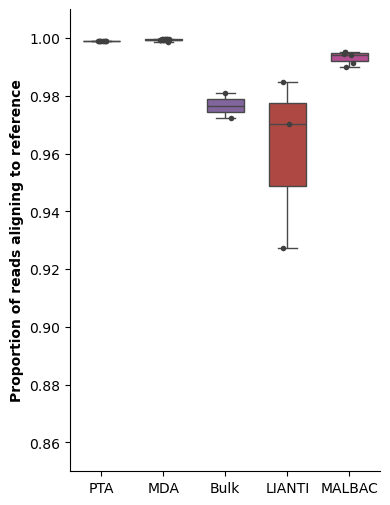

In [33]:
fig,ax = plt.subplots(1,1,figsize=(4,6))
sns.boxplot(data=meta, x="amplification_method", y="pct_reads_aligned",
            ax=ax,
            palette=pal,
            whis=(0,100),
            width=.6
           )

sns.stripplot(data=meta, x="amplification_method", y="pct_reads_aligned",
              ax=ax,
              size=4, 
              color=".25"
             )

sns.despine()
plt.xlabel('')
plt.ylim(0.85,1.01)
plt.ylabel('Proportion of reads aligning to reference', fontdict={'weight':'bold'})

/loc/scratch/39703346/ipykernel_35904/3880476779.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=meta, x="amplification_method", y="pct_duplicates",


Text(0, 0.5, 'Proportion duplicates')

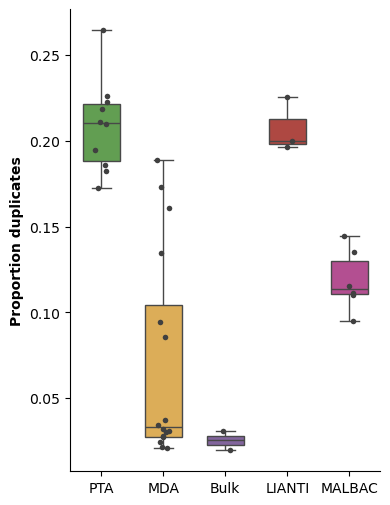

In [35]:
fig,ax = plt.subplots(1,1,figsize=(4,6))
sns.boxplot(data=meta, x="amplification_method", y="pct_duplicates",
            ax=ax,
            palette=pal,
            whis=(0,100),
            width=.6
           )

sns.stripplot(data=meta, x="amplification_method", y="pct_duplicates",
              ax=ax,
              size=4, 
              color=".25"
             )

sns.despine()
plt.xlabel('')
# plt.ylim(0.85,1.01)
plt.ylabel('Proportion duplicates', fontdict={'weight':'bold'})

/loc/scratch/39703346/ipykernel_35904/162020280.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=meta, x="amplification_method", y="gc_dropout",


Text(0, 0.5, 'GC dropout')

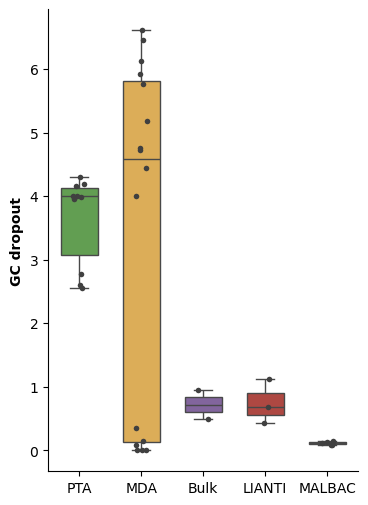

In [36]:
fig,ax = plt.subplots(1,1,figsize=(4,6))
sns.boxplot(data=meta, x="amplification_method", y="gc_dropout",
            ax=ax,
            palette=pal,
            whis=(0,100),
            width=.6
           )

sns.stripplot(data=meta, x="amplification_method", y="gc_dropout",
              ax=ax,
              size=4, 
              color=".25"
             )

sns.despine()
plt.xlabel('')
# plt.ylim(0.85,1.01)
plt.ylabel('GC dropout', fontdict={'weight':'bold'})